## Exercises

### 1. Build a MNIST Classifier that achieves over 97% accuracy on the test set

Step 1 is just assess baseline performance of the suggested KNeighbors classifier

In [5]:
from sklearn.datasets import fetch_openml

In [6]:
mnist = fetch_openml('mnist_784', version=1)

In [46]:
X, y = mnist['data'], mnist['target']

In [75]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
std_scaler = StandardScaler()

In [7]:
X_train_scaled = std_scaler.fit_transform(X_train)

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [9]:
knn_clf = KNeighborsClassifier()
knn_clf

KNeighborsClassifier()

In [10]:
# cross_val_score(knn_clf, X_train_scaled, y_train, cv=3,
#                 scoring='accuracy', verbose=2, n_jobs=-1)

Tune KNN by adjusting number of neighbours

In [11]:
from sklearn.model_selection import GridSearchCV

- Note: do not use large values for K

In [12]:
knn_param_grid = {'n_neighbors': [3, 4, 5],
                  'weights': ['uniform', 'distance']}

In [13]:
# knn_grid_search = GridSearchCV(knn_clf, knn_param_grid,
#                                scoring='accuracy',
#                                return_train_score=True,
#                                cv=3, n_jobs=4, verbose=3)

In [14]:
# knn_grid_search

In [15]:
# knn_grid_search.fit(X_train_scaled, y_train)

In [16]:
# knn_grid_search.best_params_

In [95]:
import pickle

In [96]:
# pickle.dump(knn_grid_search, open( "knn_grid_search.p", "wb" ))

In [97]:
knn_grid_search = pickle.load(open("knn_grid_search.p", "rb" ))

In [98]:
knn_grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [21]:
knn_grid_search.best_score_

0.9437666666666668

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
X_test_scaled = std_scaler.transform(X_test)

In [ ]:
y_pred = knn_grid_search.predict(X_test_scaled)

In [27]:
accuracy_score(y_test, y_pred)

0.9489

Note: KNN seems to perform worse on scaled features than unscaled - perhaps with unstructured data like MNIST it makes sense to just keep the raw features.

### 2. Write a function that can shift a MNIST image in any direction (up, down, left, right). Make four shifted copies (one per direction) and add them to the training set. Retrain your best classifier on them and see performance improve 

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
from scipy.ndimage.interpolation import shift
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [6]:
some_digit = X_train[np.random.randint(len(X_train))]

In [7]:
some_digit.shape

(784,)

In [8]:
some_digit_image = some_digit.reshape(28,28)

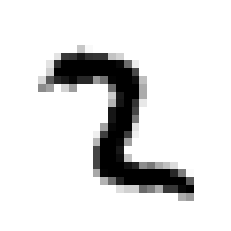

In [9]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [10]:
# test shifting left
some_digit_image_left = shift(some_digit_image, (0,-1), cval=0)

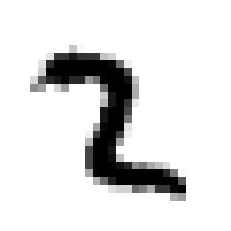

In [11]:
plt.imshow(some_digit_image_left, cmap='binary')
plt.axis('off')
plt.show()

In [12]:
def shift_digit(digit, shift_vals):
    digit_img = digit.reshape(28,28)
    digit_shifted = shift(digit_img, shift_vals, cval=0)
    return digit_shifted.reshape(-1,)

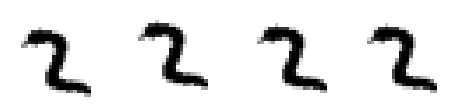

In [13]:
shift_directions = [(1,0), (-1,0), (0,1), (0,-1)]

plt.figure(figsize=(8,4))
for i in range(len(shift_directions)):
    subplot_num = int(f"1{len(shift_directions)}{i+1}")
    plt.subplot(subplot_num)
    shifted_img = shift_digit(some_digit, shift_directions[i]).reshape(28,28)
    plt.imshow(shifted_img, cmap='binary')
    plt.axis('off')


In [14]:
X_train.shape

(60000, 784)

In [15]:
X_train_augmented = [digit for digit in X_train]
y_train_augmented = [label for label in y_train]

In [16]:
for i in range(len(X_train)):
    digit = X_train_augmented[i]
    target_class = y_train_augmented[i]
    for direction in shift_directions:
        shifted_digit = shift_digit(digit, direction)
        X_train_augmented.append(shifted_digit)
        y_train_augmented.append(target_class)
    if i % 10000 == 0:
        print(f'processed {i} digits')

processed 0 digits
processed 10000 digits
processed 20000 digits
processed 30000 digits
processed 40000 digits
processed 50000 digits


In [17]:
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [18]:
X_train_augmented.shape

(300000, 784)

In [19]:
y_train_augmented.shape

(300000,)

In [23]:
# import pickle

In [24]:
# knn_grid_search = pickle.load(open("knn_grid_search.p", "rb" ))
# best_knn_clf = knn_grid_search.best_estimator_

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
best_knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')
best_knn_clf

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [27]:
best_knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [28]:
y_pred_knn_best = best_knn_clf.predict(X_test)

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
accuracy_score(y_test, y_pred_knn_best)

0.9763

## Build a Spam Classifier

In [55]:
import requests
from bs4 import BeautifulSoup
import os
import tarfile

In [35]:
corpus_url = 'https://spamassassin.apache.org/old/publiccorpus/'
r = requests.get(corpus_url)

In [41]:
soup = BeautifulSoup(r.text)

In [49]:
soup.find_all("a")[5].text

'20021010_easy_ham.tar.bz2'

In [71]:
def download_corpus_files(target_dir='email_corpus'):
    corpus_url = 'https://spamassassin.apache.org/old/publiccorpus/'
    r = requests.get(corpus_url)
    soup = BeautifulSoup(r.text)
    
    os.makedirs(target_dir, exist_ok=True)
    
    for link in soup.find_all('a'):
        if link.text.endswith('.tar.bz2'):
            download_url = os.path.join(corpus_url, link.text)
            with requests.get(download_url, stream=True) as raw:
                bz2_path = os.path.join(target_dir, link.text)
                with open(bz2_path, 'wb') as file:
                    for chunk in raw.iter_content(1024**3):
                        file.write(chunk)
            tar_file = tarfile.open(bz2_path, "r:bz2")
            tar_file.extractall(target_dir)
            tar_file.close()
            os.remove(bz2_path)             

In [72]:
download_corpus_files()

In [74]:
import numpy as np
import shutil

In [124]:
def create_train_test_datasets(corpus='email_corpus', train_size=0.8, seed=42):
    np.random.seed(seed)
    
    train_dir = os.path.join(corpus, "train")
    test_dir = os.path.join(corpus, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    email_dirs = [dir_ for dir_ in os.listdir(corpus) if "am" in dir_]
    
    target_counts = {"spam": 0, "ham": 0}
    
    for dir_ in email_dirs:
        if "spam" in dir_: target = "spam"
        else: target = "ham"
        email_dir = os.path.join(corpus, dir_)
        emails = os.listdir(email_dir)
        emails.remove("cmds")
        emails_shuffled_ix = np.random.randint(0, len(emails),
                                               size=(len(emails)))
        train_ix = emails_shuffled_ix[:(int(len(emails)*train_size))]
        test_ix = emails_shuffled_ix[(int(len(emails)*train_size)):]
        for ix in train_ix:
            src_file = os.path.join(email_dir, emails[ix])
            dest_file = target + str(target_counts[target])
            shutil.copy(src_file, os.path.join(train_dir, dest_file))
            target_counts[target] += 1
        for ix in test_ix:
            src_file = os.path.join(email_dir, emails[ix])
            dest_file = target + str(target_counts[target])
            shutil.copy(src_file, os.path.join(test_dir, dest_file))
            target_counts[target] += 1
        
            
            

In [125]:
create_train_test_datasets()